In [172]:
%matplotlib widget

from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np

In [173]:
# functions for simulating Geometric Brownian Motion (GBM)
MU = 0.05
SIGMA = 0.2
Y0 = 1


def bm_gen(T, dt, num_paths):
    """Simulate a single path of brownian motion

    Inputs
    ------
    T: floating point variable, greater than 0, final time 
    dt: time increment of the simulation

    Returns
    -------
    bmotion: single path of a brownian motion simulation (nsamples, npaths)
    """
    nsamples = int(np.ceil(T / dt)) + 1
    samples = np.random.randn(nsamples, num_paths) * np.sqrt(dt)
    samples[0] = 0.0
    bmotion = np.cumsum(samples, axis=0)
    return bmotion


def bm_f2c(T, dt, brownian_fine, M):
    """Extract a sample of a coarse brownian motion simulation from a fine brownian motion simulation"""

    nsamples = int(np.ceil(T/dt)) + 1
    npaths = brownian_fine.shape[1]
    brownian_coarse = np.zeros((nsamples, npaths))
    brownian_coarse[0, :] = brownian_fine[0, :]
    for ii in range(1, nsamples):
        delta = brownian_fine[ii * M, :] - brownian_fine[(ii-1)*M, :]
        brownian_coarse[ii, :] = brownian_coarse[ii-1, :] + delta
    return brownian_coarse


def euler_maruyama(b, h, y0, dt, T, bmotion):
    """Perform Euler Maruyama integration to integrate a one dimensional SDE

        dX = b(t, X) dt + h(t, X) dW

    Inputs
    ------
    b: function taking input of a single time and a vector of (Npaths) values X
    h: function taking input of a single time and a vector of (Npaths) values X
    y0: initial condition (Npaths, )
    dt: time step
    T: final time
    bmotion: a brownian motion simulation (Nsteps, Npaths) that is consistent with dt and T

    Returns
    -------
    times: time incrememnts
    paths: (Nsteps, npaths)
    """

    num_paths = y0.shape[0]
    assert bmotion.shape[1] >= num_paths, "Not enough brownian motions simulated"
    num_steps = int(np.ceil(T / dt)) + 1
    paths = np.zeros((num_steps, num_paths))
    paths[0, :] = y0
    times = np.zeros(num_steps)
    t = 0
    for ii in range(1, num_steps):
        paths[ii, :] = paths[ii-1, :] + b(t, paths[ii-1, :]) * dt + \
            h(t, paths[ii-1, :]) * (bmotion[ii, :] - bmotion[ii-1, :])
        t += dt
        times[ii] = t
    return times, paths


def gbm_analytic(y0, mu, sigma, t, bmotion):
    return y0 * np.exp((mu - (sigma**2)/2) * t + SIGMA * bmotion)


def bfunc(t, y):
    return MU * y


def hfunc(t, y):
    return SIGMA * y

Using simulations for Y(1)
Mean: 1.057589958620039
Variance: 0.04700753804749222
Using analytic solution for Y(1) directly
Mean: 1.0577752236551305
Variance: 0.04711968036403651
Full analytic solution for Y(1)
Mean: 1.0512710963760241
Variance: 0.04510288078157963
MC estimator variance: 4.700753804749222e-05


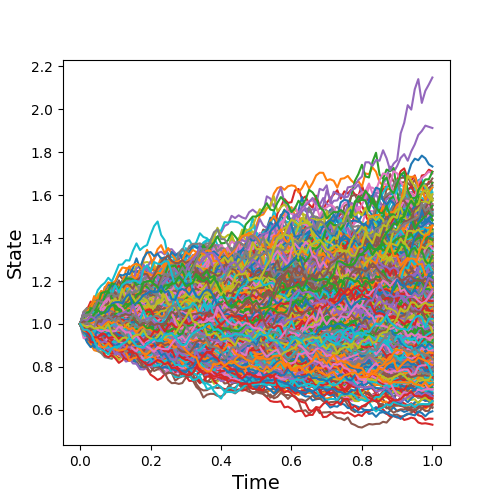

In [174]:
# 4.1 just simulate

def gbm_sim(dt, bmotion):
    y0 = np.ones((bmotion.shape[1]))  # start at 1
    return euler_maruyama(bfunc, hfunc, y0, dt, T, bmotion)


num_paths = 1000
T = 1
dt = 0.01
bmotion = bm_gen(T, dt, num_paths)
times, states = gbm_sim(dt, bmotion)
mean_y1 = np.mean(states[-1, :])  # this is basically the MC estimate
var_y1 = np.var(states[-1, :])
print(f"Using simulations for Y(1)\nMean: {mean_y1}\nVariance: {var_y1}")
mean_y1_analytic = np.mean(gbm_analytic(Y0, MU, SIGMA, T, bmotion[-1, :]))
var_y1_analytic = np.var(gbm_analytic(Y0, MU, SIGMA, T, bmotion[-1, :]))
print(
    f"Using analytic solution for Y(1) directly\nMean: {mean_y1_analytic}\nVariance: {var_y1_analytic}")

# full analytic solution without any samples, refer to report for derivation:
exp1 = np.exp(MU - SIGMA**2/2)
exp_norm_var = 1 * SIGMA**2
norm_exp_mean = np.exp(SIGMA**2 / 2)
norm_exp_var = (np.exp(SIGMA**2) - 1) * np.exp(SIGMA**2)
Y1_mean = exp1 * norm_exp_mean
Y1_var = exp1**2 * norm_exp_var
print(f"Full analytic solution for Y(1)\nMean: {Y1_mean}\nVariance: {Y1_var}")

print(f"MC estimator variance: {var_y1/num_paths}")

plt.figure(figsize=(5, 5))
plt.plot(times, states)
plt.xlabel('Time', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.savefig('figs/4.1.svg')

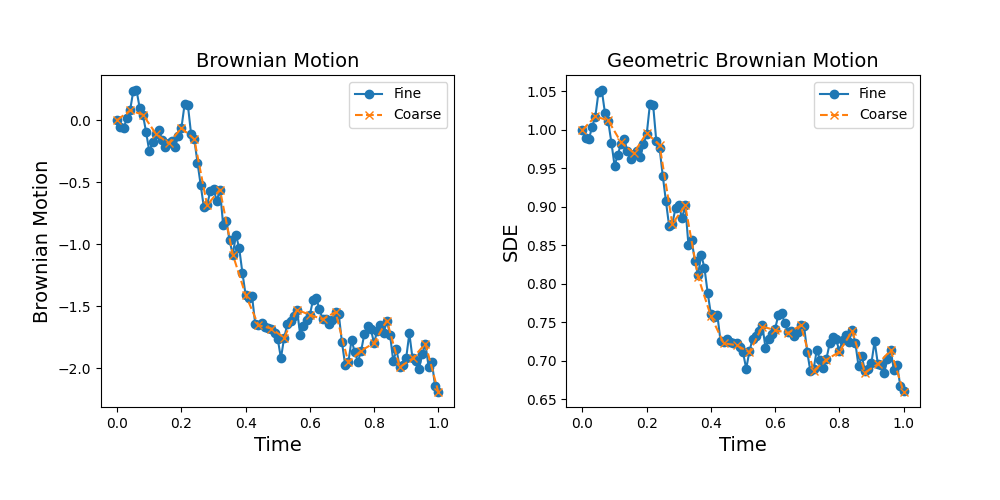

In [175]:
# 4.2 simulate both fine and coarse

def gbm_sim_fine_coarse(dt_fine, bmotion_fine):
    _, states_fine = gbm_sim(dt_fine, bmotion_fine)
    bmotion_coarse = bm_f2c(T, dt_fine * M, bmotion_fine, M)
    _, states_coarse = gbm_sim(dt_fine * M, bmotion_coarse)
    return states_fine, states_coarse


M = 4
bmotion_fine = bmotion
bmotion_coarse = bm_f2c(T, dt * M, bmotion_fine, M)  # just doing it so can plot
states_fine, states_coarse = gbm_sim_fine_coarse(dt, bmotion_fine)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)

ax[0].plot(times, bmotion_fine[:, 0], 'o', label='Fine', linestyle='-')
ax[0].plot(times[::4], bmotion_coarse[:, 0], "x", label='Coarse', linestyle='--')
ax[0].set_xlabel('Time', fontsize=14)
ax[0].set_ylabel('Brownian Motion', fontsize=14)
ax[0].set_title('Brownian Motion', fontsize=14)
ax[0].legend()

ax[1].plot(times, states_fine[:, 0], 'o', label='Fine', linestyle='-')
ax[1].plot(times[::4], states_coarse[:, 0], "x", label='Coarse', linestyle='--')
ax[1].set_xlabel('Time', fontsize=14)
ax[1].set_ylabel('SDE', fontsize=14)
ax[1].set_title('Geometric Brownian Motion', fontsize=14)
ax[1].legend()

fig.savefig('figs/4.2.svg')

In [176]:
def full_sim_fine_coarse(dt_fine, bmotion_fine):
    _, y_fine = gbm_sim(dt_fine, bmotion_fine)
    p_fine = np.exp(-0.05)*np.maximum(0, y_fine[-1, :] - 1)
    bmotion_coarse = bm_f2c(T, dt_fine * M, bmotion_fine, M)
    _, y_coarse = gbm_sim(dt_fine * M, bmotion_coarse)
    p_coarse = np.exp(-0.05)*np.maximum(0, y_coarse[-1, :] - 1)
    return y_fine, y_coarse, p_fine, p_coarse


@dataclass
class MLMCResult:
    y_exp: float
    p_exp: float
    y_mean_l: np.ndarray
    p_mean_l: np.ndarray
    y_var: float
    p_var: float
    y_var_l: np.ndarray
    p_var_l: np.ndarray
    y_corrcoef_l: np.ndarray
    p_corrcoef_l: np.ndarray
    p_finest: np.ndarray


def mlmc(nsamples):
    """Multilevel Monte Carlo for Stochastic differential equations"""
    ###########################
    # level 2 Only coarse grid evaluations are used
    ###########################
    dt_l2 = M**(-2)
    bmotion_l2 = bm_gen(T, dt_l2, nsamples[0])
    _, y_l2 = gbm_sim(dt_l2, bmotion_l2)
    y_l2 = y_l2[-1, :]
    p_l2 = np.exp(-0.05)*np.maximum(0, y_l2 - 1)

    #####################
    # level 3
    ######################
    dt_fine_l3 = M**(-3)
    bmotion_fine_l3 = bm_gen(T, dt_fine_l3, nsamples[1])  # generate fine bmotion samples
    y_fine_l3, y_coarse_l3, p_fine_l3, p_coarse_l3 = full_sim_fine_coarse(
        dt_fine_l3, bmotion_fine_l3)
    y_fine_l3 = y_fine_l3[-1, :]  # take the final sample
    y_coarse_l3 = y_coarse_l3[-1, :]  # take the final sample
    y_delta_l3 = y_fine_l3 - y_coarse_l3  # subtract to get delta
    p_delta_l3 = p_fine_l3 - p_coarse_l3  # subtract to get delta

    #####################
    # level 4
    ######################
    dt_fine_l4 = M**(-4)
    bmotion_fine_l4 = bm_gen(T, dt_fine_l4, nsamples[2])
    y_fine_l4, y_coarse_l4, p_fine_l4, p_coarse_l4 = full_sim_fine_coarse(
        dt_fine_l4, bmotion_fine_l4)
    y_fine_l4 = y_fine_l4[-1, :]
    y_coarse_l4 = y_coarse_l4[-1, :]
    y_delta_l4 = y_fine_l4 - y_coarse_l4
    p_delta_l4 = p_fine_l4 - p_coarse_l4

    #####################
    # level 5
    ######################
    dt_fine_l5 = M**(-5)
    bmotion_fine_l5 = bm_gen(T, dt_fine_l5, nsamples[2])
    y_fine_l5, y_coarse_l5, p_fine_l5, p_coarse_l5 = full_sim_fine_coarse(
        dt_fine_l5, bmotion_fine_l5)
    y_fine_l5 = y_fine_l5[-1, :]
    y_coarse_l5 = y_coarse_l5[-1, :]
    y_delta_l5 = y_fine_l5 - y_coarse_l5
    p_delta_l5 = p_fine_l5 - p_coarse_l5

    #####################
    # Combine levels
    #####################
    y_mean_l = np.array([np.mean(y_l2), np.mean(y_delta_l3),
                         np.mean(y_delta_l4), np.mean(y_delta_l5)])
    y_exp = np.sum(y_mean_l)
    p_mean_l = np.array([np.mean(p_l2), np.mean(p_delta_l3),
                         np.mean(p_delta_l4), np.mean(p_delta_l5)])
    p_exp = np.sum(p_mean_l)

    y_var_l = np.array([np.var(y_l2), np.var(y_delta_l3), np.var(y_delta_l4), np.var(y_delta_l5)])
    y_var = np.sum(y_var_l/nsamples)
    p_var_l = np.array([np.var(p_l2), np.var(p_delta_l3), np.var(p_delta_l4), np.var(p_delta_l5)])
    p_var = np.sum(p_var_l/nsamples)

    y_corrcoef_l = np.array([np.corrcoef(y_coarse_l3, y_fine_l3)[0, 1], np.corrcoef(
        y_coarse_l4, y_fine_l4)[0, 1], np.corrcoef(y_coarse_l5, y_fine_l5)[0, 1]])
    p_corrcoef_l = np.array([np.corrcoef(p_coarse_l3, p_fine_l3)[0, 1], np.corrcoef(
        p_coarse_l4, p_fine_l4)[0, 1], np.corrcoef(p_coarse_l5, p_fine_l5)[0, 1]])
    return MLMCResult(y_exp, p_exp, np.abs(y_mean_l), np.abs(p_mean_l), y_var, p_var, y_var_l,
                      p_var_l, y_corrcoef_l, p_corrcoef_l, p_fine_l5)


nsample = 10**5
nsamples = [nsample, nsample, nsample, nsample]
mlmc_res = mlmc(nsamples)

Monte Carlo Estimate Y1: 1.0515921104549901 with variance 4.455011828906813e-07
Vs analytic solution: 0.03%
Correlation Coefficients
L3: 0.9995235822127302
L4: 0.9998811041302048
L5: 0.9999699356524651
Monte Carlo Estimate P: 0.10456286429743193 with variance 2.1146133346605336e-07
Correlation Coefficients
L3: 0.9993854411341213
L4: 0.9998436500610987
L5: 0.9999601517928206


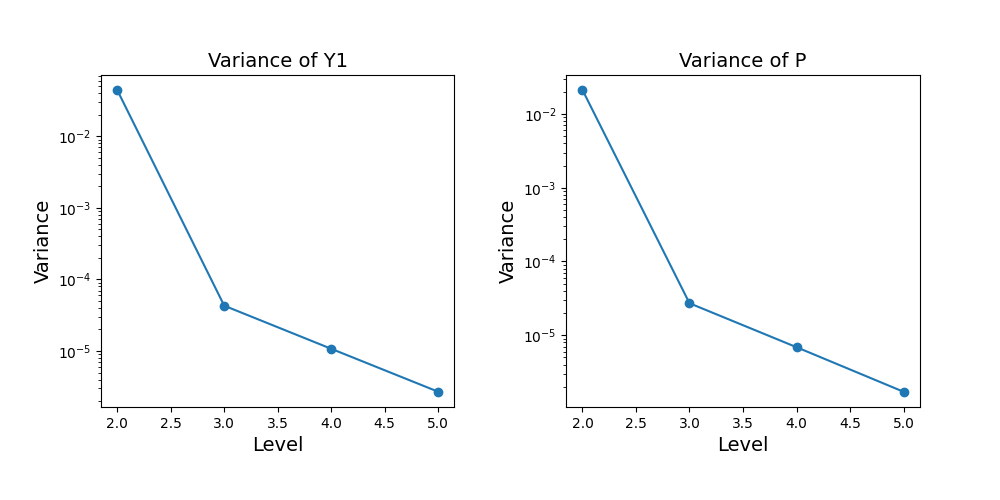

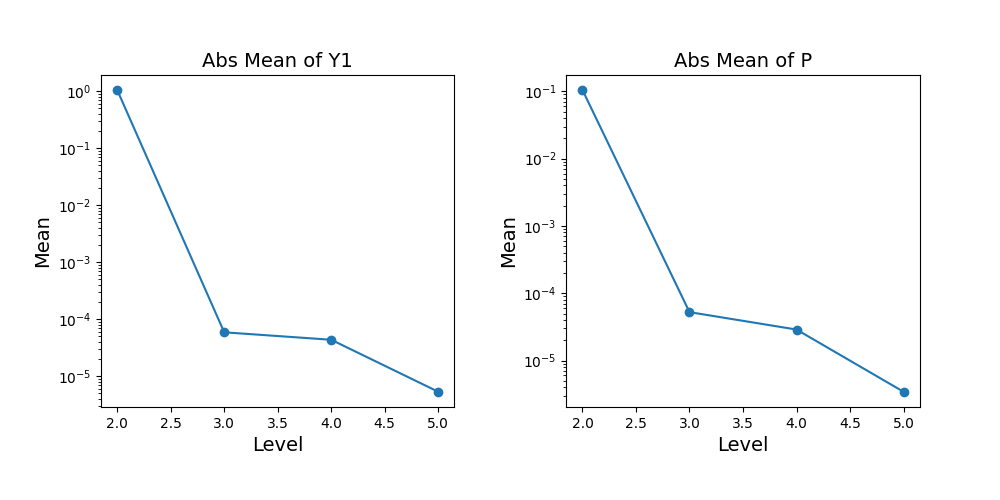

In [177]:
print(f"Monte Carlo Estimate Y1: {mlmc_res.y_exp} with variance {mlmc_res.y_var}")
print(f"Vs analytic solution: {np.abs(Y1_mean-mlmc_res.y_exp)/Y1_mean*100:.2f}%")
# print(
#     f"Variance of Y1\nL2: {mlmc_res.y_var_l[0]}\nL3: {mlmc_res.y_var_l[1]}\nL4: {mlmc_res.y_var_l[2]}\nL5: {mlmc_res.y_var_l[3]}")
print(
    f"Correlation Coefficients\nL3: {mlmc_res.y_corrcoef_l[0]}\nL4: {mlmc_res.y_corrcoef_l[1]}\nL5: {mlmc_res.y_corrcoef_l[2]}")

print(f"Monte Carlo Estimate P: {mlmc_res.p_exp} with variance {mlmc_res.p_var}")
# print(
#     f"Variance of P\nL2: {mlmc_res.p_var_l[0]}\nL3: {mlmc_res.p_var_l[1]}\nL4: {mlmc_res.p_var_l[2]}\nL5: {mlmc_res.p_var_l[3]}")
print(
    f"Correlation Coefficients\nL3: {mlmc_res.p_corrcoef_l[0]}\nL4: {mlmc_res.p_corrcoef_l[1]}\nL5: {mlmc_res.p_corrcoef_l[2]}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.tight_layout(pad=5)

ax[0].semilogy([2, 3, 4, 5], mlmc_res.y_var_l, 'o', label='Variance', linestyle='-')
ax[0].set_xlabel('Level', fontsize=14)
ax[0].set_ylabel('Variance', fontsize=14)
ax[0].set_title('Variance of Y1', fontsize=14)

ax[1].semilogy([2, 3, 4, 5], mlmc_res.p_var_l, 'o', label='Variance', linestyle='-')
ax[1].set_xlabel('Level', fontsize=14)
ax[1].set_ylabel('Variance', fontsize=14)
ax[1].set_title('Variance of P', fontsize=14)

fig.savefig('figs/4.3.svg')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.tight_layout(pad=5)

ax[0].semilogy([2, 3, 4, 5], mlmc_res.y_mean_l, 'o', label='Mean', linestyle='-')
ax[0].set_xlabel('Level', fontsize=14)
ax[0].set_ylabel('Mean', fontsize=14)
ax[0].set_title('Abs Mean of Y1', fontsize=14)

ax[1].semilogy([2, 3, 4, 5], mlmc_res.p_mean_l, 'o', label='Mean', linestyle='-')
ax[1].set_xlabel('Level', fontsize=14)
ax[1].set_ylabel('Mean', fontsize=14)
ax[1].set_title('Abs Mean of P', fontsize=14)

fig.savefig('figs/4.4.svg')

Total cost: 169600000
Optimal sample allocation: [2621090.   42044.   10590.    2642.]
Sample required for MC: 2148327.0


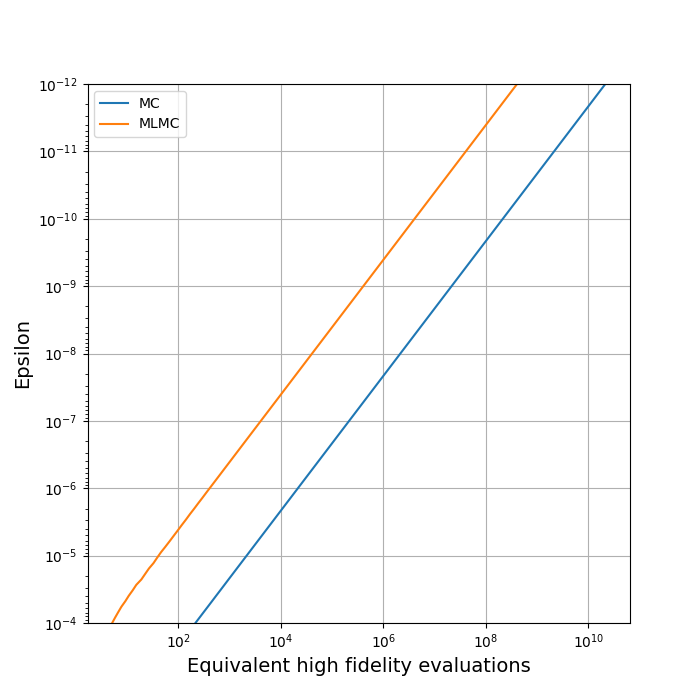

In [185]:
# cost breakdown
from numpy import size


cost_l = np.array([M**2, M**3 + M**2, M**4 + M**3, M**5 + M**4])
costs = (cost_l * nsamples)
print(f"Total cost: {np.sum(costs)}")

# 4.1.4 optimal sample allocation


def get_opt_nsamples_mlmc(epsilonsq, costs, variances):
    lamb = epsilonsq**(-1)*np.sum(np.sqrt(variances * costs))
    # print(f"Lambda: {lamb}")
    return np.ceil(lamb * np.sqrt(variances / costs))


epsilonsq = 10**-8
nsamples_opt_mlmc = get_opt_nsamples_mlmc(epsilonsq, costs, mlmc_res.p_var_l)
print(f"Optimal sample allocation: {nsamples_opt_mlmc}")

# 4.1.5 optimal sample allocation for MC


def get_nsamples_mc(epsilonsq, variances):
    return np.ceil(variances / epsilonsq)


var_finest = np.var(mlmc_res.p_finest)
# print(var_finest)
nsamples_mc = get_nsamples_mc(epsilonsq, var_finest)
print(f"Samples required for MC: {nsamples_mc}")

# plotting for various epsilons
epsilonsqs = 10**np.linspace(-12, -4, 100)
evals_mc = []
evals_mlmc = []
for epsilonsq in epsilonsqs:
    nsamples_mc = get_nsamples_mc(epsilonsq, var_finest)
    evals_mc.append(nsamples_mc)
    nsamples_opt_mlmc = get_opt_nsamples_mlmc(epsilonsq, costs, mlmc_res.p_var_l)
    cost_mlmc = np.sum(nsamples_opt_mlmc * cost_l)
    evals_mlmc.append(cost_mlmc/cost_l[-1])

plt.figure(figsize=(7, 7))
plt.tight_layout(pad=5)
plt.loglog(evals_mc, epsilonsqs, label='MC')
plt.loglog(evals_mlmc, epsilonsqs, label='MLMC')
plt.ylim(max(epsilonsqs), min(epsilonsqs))  # flip axes
plt.xlabel('Equivalent high fidelity evaluations', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.legend()
plt.grid()
plt.savefig('figs/4.5.svg')